In [1]:
import numpy as np
import supervision as sv

import torch
import intel_extension_for_pytorch as ipex
from PIL import Image
import matplotlib.pyplot as plt

/home/wayne/ov/.env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device('xpu')

In [3]:
from collections import OrderedDict
from groundingdino.util.slconfig import SLConfig
from groundingdino.models import build_model

def clean_state_dict(state_dict):
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if k[:7] == "module.":
            k = k[7:]  # remove `module.`
        new_state_dict[k] = v
    return new_state_dict

def load_model(model_config_path, model_checkpoint_path, bert_path):
    args = SLConfig.fromfile(model_config_path)
    args.device = "cpu"
    args.text_encoder_type = bert_path
    model = build_model(args)
    checkpoint = torch.load(model_checkpoint_path, map_location="cpu")
    load_res = model.load_state_dict(clean_state_dict(checkpoint["model"]), strict=False)
    #print(load_res)
    _ = model.eval()
    return model

/home/wayne/ov/GroundingDINO/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [4]:
GDINO_CONFIG_PATH = "config/GroundingDINO_SwinT_OGC.py"
GDINO_CHECKPOINT_PATH = "checkpoints/groundingdino_swint_ogc.pth"
BERT_PATH = "checkpoints/bert-base-uncased"
gdino = load_model(GDINO_CONFIG_PATH, GDINO_CHECKPOINT_PATH, BERT_PATH)

/home/wayne/ov/.env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /build/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: checkpoints/bert-base-uncased


In [5]:
_ = gdino.to(device)

In [6]:
model = ipex.optimize(gdino)

/home/wayne/ov/.env/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:611: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn(
/home/wayne/ov/.env/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:618: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn(


In [7]:
import torchvision.transforms as T
def load_image(image_path, size=[512,512]):
    # load image
    image_pil = Image.open(image_path).convert("RGB")  # load image
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image = transform(image_pil)
    return image_pil, image

In [8]:
image_pil, image = load_image("assets/cats.png")

In [9]:
image = image[None].to(device)

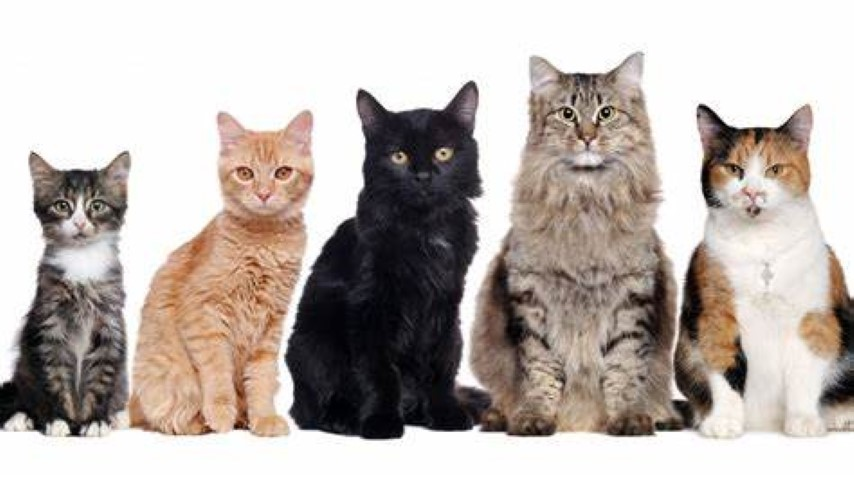

In [10]:
image_pil

In [10]:
from typing import Dict
from transformers import AutoTokenizer
def get_phrases_from_posmap(
            posmap: torch.BoolTensor,
            tokenized: Dict,
            tokenizer: AutoTokenizer,
            left_idx: int = 0, right_idx: int = 255):
    if posmap.dim() == 1:
        posmap[0: left_idx + 1] = False
        posmap[right_idx:] = False
        non_zero_idx = posmap.nonzero(as_tuple=True)[0].tolist()
        token_ids = [tokenized["input_ids"][i] for i in non_zero_idx]
        return tokenizer.decode(token_ids)
    else:
        raise NotImplementedError("posmap must be 1-dim")

In [11]:
def get_grounding_output(model, image, caption, box_threshold=.3, text_threshold=.25):
    caption = caption.strip().lower()
    if not caption.endswith("."):
        caption = caption + "."
    with torch.no_grad():
        outputs = model(image, captions=[caption])
    logits = outputs["pred_logits"].sigmoid()[0]
    boxes = outputs["pred_boxes"][0]
    # filter output
    logits_filt = logits.cpu().clone()
    boxes_filt = boxes.cpu().clone()
    filt_mask = logits_filt.max(dim=1)[0] > box_threshold
    logits_filt = logits_filt[filt_mask]
    boxes_filt = boxes_filt[filt_mask]

    # get phrase
    tokenized = model.tokenizer(caption)
    # build pred
    pred_phrases = [get_phrases_from_posmap(logit > text_threshold, tokenized, model.tokenizer) for logit in logits_filt]
    return boxes_filt, logits_filt.max(dim=1)[0], pred_phrases

In [12]:
from torchvision.ops import box_convert

def post_process_result(
        source_h: int,
        source_w: int,
        boxes: torch.Tensor,
        logits: torch.Tensor
) -> sv.Detections:
    boxes = boxes * torch.Tensor([source_w, source_h, source_w, source_h])
    xyxy = box_convert(boxes=boxes, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    confidence = logits.numpy()
    return sv.Detections(xyxy=xyxy, confidence=confidence)

In [13]:
text_prompt = "cat"

In [14]:
boxes, logits, pred_phrases = get_grounding_output(model, image, text_prompt)

/home/wayne/ov/.env/lib/python3.10/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/wayne/ov/.env/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [15]:
w, h = image_pil.size
detections = post_process_result(h, w, boxes, logits)

In [16]:
# annotate image with detections
box_annotator = sv.BoxAnnotator()
labels = [
    f"{text_prompt} {confidence:0.2f}" 
    for _, _, confidence, _, _ 
    in detections]
annotated_image = box_annotator.annotate(scene=np.array(image_pil), detections=detections, labels=labels)

In [17]:
detections.xyxy[0]

array([  0.     , 149.92139, 131.66528, 436.6665 ], dtype=float32)

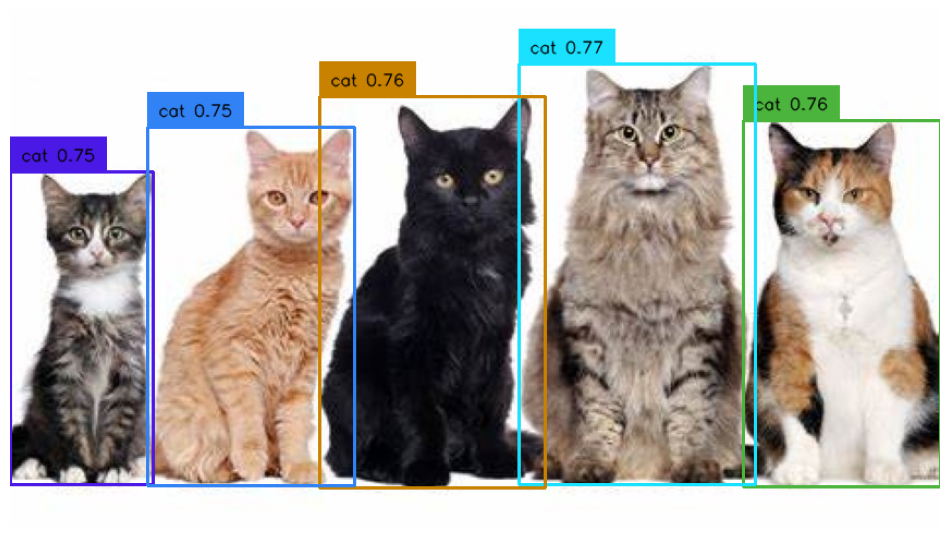

In [18]:
plt.figure(figsize=(12,10))
plt.imshow(annotated_image)
plt.axis('off')
plt.show()

In [19]:
%timeit get_grounding_output(model, image, text_prompt)

163 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
def func(model, image, caption):
    with torch.no_grad():
        model(image, captions=[caption])

In [20]:
%pdb

Automatic pdb calling has been turned ON


In [24]:
%timeit func(model, image, "cat.")

161 ms ± 481 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
model = gdino.half().to(device)
image = image.half()

In [13]:
_ = model(image, captions=['cat.'])

/home/wayne/ov/.env/lib/python3.10/site-packages/transformers/modeling_utils.py:900: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [ ]:
func(model, image, "cat.")

In [ ]:
%timeit func(model, image, "cat.")

In [32]:
%timeit get_grounding_output(model, image, text_prompt)

333 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
